# Restaurant Review Classifiers

## Overview
This notebook demonstrates a multi-output classification model for restaurant reviews, predicting food, service, and atmosphere ratings.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [2]:
class RestaurantReviewClassifier:
    def __init__(self, model='logistic_regression'):
        self.tfidf_vectorizer = TfidfVectorizer(
            stop_words='english',
            max_features=5000,
            ngram_range=(1, 2)
        )
        self.label_encoders = {
            'food': LabelEncoder(),
            'service': LabelEncoder(),
            'atmosphere': LabelEncoder()
        }

        # Initialize classifier based on input model
        if model == 'logistic_regression':
            base_classifier = LogisticRegression(max_iter=1000)
        elif model == 'random_forest':
            base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        elif model == 'svm':
            base_classifier = SVC(probability=True, kernel='linear')
        else:
            raise ValueError("Model not supported. Choose from 'logistic_regression', 'random_forest', 'svm'.")

        self.classifier = MultiOutputClassifier(base_classifier)

    def preprocess_data(self, df):
        # Drop rows with NaN in text column
        df = df.dropna(subset=['text'])

        # Fill NaN in categorical columns with 'None'
        columns = ['food', 'service', 'atmosphere']
        for col in columns:
            if col not in df.columns:
                df[col] = 'None'
            df.loc[:, col] = df[col].fillna('None')

        return df

    def train(self, df):
        # Preprocess data
        df = self.preprocess_data(df)

        # Vectorize text
        X = self.tfidf_vectorizer.fit_transform(df['text'].astype(str))

        # Encode labels dynamically
        y_dict = {}
        for col in ['food', 'service', 'atmosphere']:
            unique_labels = df[col].unique()
            self.label_encoders[col].fit(unique_labels)
            y_dict[col] = self.label_encoders[col].transform(df[col])

        y = pd.DataFrame(y_dict)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Train classifier
        self.classifier.fit(X_train, y_train)

        # Predict
        y_pred = self.classifier.predict(X_test)

        # Evaluate
        print("\nModel Performance Metrics:")
        for i, col in enumerate(['food', 'service', 'atmosphere']):
            print(f"\n{col.capitalize()} Classification:")
            classes = self.label_encoders[col].classes_

            accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
            print(f"Accuracy: {accuracy:.2%}")

            print(classification_report(
                y_test.iloc[:, i],
                y_pred[:, i],
                labels=range(len(classes)),
                target_names=classes
            ))

    def predict(self, texts):
        # Convert texts to strings and handle potential NaN
        texts = [str(text) if pd.notna(text) else '' for text in texts]

        # Vectorize input
        X = self.tfidf_vectorizer.transform(texts)

        # Predict
        predictions = self.classifier.predict(X)

        # Decode predictions
        results = []
        for pred in predictions:
            result = {
                col: self.label_encoders[col].inverse_transform([p])[0]
                for col, p in zip(['food', 'service', 'atmosphere'], pred)
            }
            results.append(result)

        return results


In [3]:
# Logistic Regression
classifier_lr = RestaurantReviewClassifier(model='logistic_regression')

# Random Forest
classifier_rf = RestaurantReviewClassifier(model='random_forest')

# Support Vector Machine
classifier_svm = RestaurantReviewClassifier(model='svm')


In [4]:
df = pd.read_csv('../raw_data/clean_data.csv')  # Load your dataset

df_low_score = df[df['rating'] < 5]

# Sample 500 reviews with a score of 5
df_score_5_sample = df[df['rating'] == 5].sample(n=300, random_state=42)

# Combine the two DataFrames
df_filtered = pd.concat([df_low_score, df_score_5_sample])

# Reset the index if needed
df_filtered.reset_index(drop=True, inplace=True)

df = df_filtered

# Train using Logistic Regression
classifier_lr.train(df)

# Train using Random Forest
classifier_rf.train(df)

# Train using SVM
classifier_svm.train(df)



Model Performance Metrics:

Food Classification:
Accuracy: 68.10%
              precision    recall  f1-score   support

    Negative       0.69      0.33      0.45        66
        None       1.00      0.04      0.07        27
    Positive       0.68      0.97      0.80       139

    accuracy                           0.68       232
   macro avg       0.79      0.45      0.44       232
weighted avg       0.72      0.68      0.61       232


Service Classification:
Accuracy: 71.98%
              precision    recall  f1-score   support

    Negative       0.79      0.55      0.65        62
        None       0.66      0.77      0.71        87
    Positive       0.75      0.80      0.77        83

    accuracy                           0.72       232
   macro avg       0.73      0.70      0.71       232
weighted avg       0.73      0.72      0.72       232


Atmosphere Classification:
Accuracy: 77.59%
              precision    recall  f1-score   support

    Negative       0.00      

/Users/aneta/opt/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aneta/opt/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aneta/opt/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Model Performance Metrics:

Food Classification:
Accuracy: 67.67%
              precision    recall  f1-score   support

    Negative       0.64      0.24      0.35        66
        None       0.71      0.19      0.29        27
    Positive       0.68      0.98      0.80       139

    accuracy                           0.68       232
   macro avg       0.68      0.47      0.48       232
weighted avg       0.67      0.68      0.61       232


Service Classification:
Accuracy: 70.26%
              precision    recall  f1-score   support

    Negative       0.69      0.39      0.49        62
        None       0.78      0.79      0.78        87
    Positive       0.65      0.84      0.73        83

    accuracy                           0.70       232
   macro avg       0.70      0.67      0.67       232
weighted avg       0.71      0.70      0.69       232


Atmosphere Classification:
Accuracy: 78.88%
              precision    recall  f1-score   support

    Negative       0.00      

/Users/aneta/opt/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aneta/opt/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aneta/opt/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Model Performance Metrics:

Food Classification:
Accuracy: 71.12%
              precision    recall  f1-score   support

    Negative       0.67      0.47      0.55        66
        None       0.75      0.11      0.19        27
    Positive       0.72      0.94      0.82       139

    accuracy                           0.71       232
   macro avg       0.71      0.51      0.52       232
weighted avg       0.71      0.71      0.67       232


Service Classification:
Accuracy: 72.41%
              precision    recall  f1-score   support

    Negative       0.74      0.60      0.66        62
        None       0.68      0.75      0.71        87
    Positive       0.77      0.80      0.78        83

    accuracy                           0.72       232
   macro avg       0.73      0.71      0.72       232
weighted avg       0.73      0.72      0.72       232


Atmosphere Classification:
Accuracy: 77.59%
              precision    recall  f1-score   support

    Negative       0.00      

/Users/aneta/opt/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aneta/opt/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aneta/opt/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [5]:
# load test_data_reviews
test_data = pd.read_csv('../test_data_reviews/2_9_review.csv')    

# Predict using Logistic Regression
predictions_lr = classifier_lr.predict(test_data['text'][0:5])
#print review text and predicted ratings
for i in range(5):
    print(test_data['wiI7pd'][i])
    print("Logistic Regression Predictions:", predictions_lr[i])
    print("\n")

Cudowna obsługa , pani dokładnie sprawdzająca każde danie pod względem alergii córki , życzliwość i uśmiech Pani kelnerki . Górale i muzyka tworząca  niesamowitą swojską atmosferę .  Dania bardzo smaczne , porcje ogromne , ceny przystępne . Wrócimy na 100% Dziękujemy jeszcze raz 🥰…
Logistic Regression Predictions: {'food': 'Positive', 'service': 'Positive', 'atmosphere': 'None'}


Jedliśmy żurek barszcz z uszkami placek po zbójnicku z zestawem surówek i margaritte. Żurek znośny za to barszcz był obrzydliwy do tego uszka były rozgotowane i pokaleczone o kwaśnym smaku. Placek był bez smaku a margarita to wiór do pizzy można dostać co najwyżej ketchup. Bukiet podobno 3 surówek to mały talerzyk od espresso.
Logistic Regression Predictions: {'food': 'Negative', 'service': 'None', 'atmosphere': 'None'}


Byłem w tym miejscu pierwszy raz ok 10 lat temu i wtedy w tej restauracji było mnóstwo ludzi, pyszne jedzenie w ogromnych porcjach i widać było że knajpa żyje 😊 teraz małe porcje , drogo i n

In [6]:
# Predict using Random Forest
predictions_rf = classifier_rf.predict(test_data['text'][0:5])
#print review text and predicted ratings
for i in range(5):
    print(test_data['wiI7pd'][i])
    print("Random Forest Predictions:", predictions_rf[i])
    print("\n")

Cudowna obsługa , pani dokładnie sprawdzająca każde danie pod względem alergii córki , życzliwość i uśmiech Pani kelnerki . Górale i muzyka tworząca  niesamowitą swojską atmosferę .  Dania bardzo smaczne , porcje ogromne , ceny przystępne . Wrócimy na 100% Dziękujemy jeszcze raz 🥰…
Random Forest Predictions: {'food': 'Positive', 'service': 'Positive', 'atmosphere': 'Positive'}


Jedliśmy żurek barszcz z uszkami placek po zbójnicku z zestawem surówek i margaritte. Żurek znośny za to barszcz był obrzydliwy do tego uszka były rozgotowane i pokaleczone o kwaśnym smaku. Placek był bez smaku a margarita to wiór do pizzy można dostać co najwyżej ketchup. Bukiet podobno 3 surówek to mały talerzyk od espresso.
Random Forest Predictions: {'food': 'Negative', 'service': 'None', 'atmosphere': 'None'}


Byłem w tym miejscu pierwszy raz ok 10 lat temu i wtedy w tej restauracji było mnóstwo ludzi, pyszne jedzenie w ogromnych porcjach i widać było że knajpa żyje 😊 teraz małe porcje , drogo i niczym ni

In [7]:
# Predict using SVM
predictions_svm = classifier_svm.predict(test_data['text'][0:5])
#print review text and predicted ratings
for i in range(5):
    print(test_data['wiI7pd'][i])
    print("SVM Predictions:", predictions_svm[i])
    print("\n")

Cudowna obsługa , pani dokładnie sprawdzająca każde danie pod względem alergii córki , życzliwość i uśmiech Pani kelnerki . Górale i muzyka tworząca  niesamowitą swojską atmosferę .  Dania bardzo smaczne , porcje ogromne , ceny przystępne . Wrócimy na 100% Dziękujemy jeszcze raz 🥰…
SVM Predictions: {'food': 'Positive', 'service': 'Positive', 'atmosphere': 'None'}


Jedliśmy żurek barszcz z uszkami placek po zbójnicku z zestawem surówek i margaritte. Żurek znośny za to barszcz był obrzydliwy do tego uszka były rozgotowane i pokaleczone o kwaśnym smaku. Placek był bez smaku a margarita to wiór do pizzy można dostać co najwyżej ketchup. Bukiet podobno 3 surówek to mały talerzyk od espresso.
SVM Predictions: {'food': 'Negative', 'service': 'None', 'atmosphere': 'None'}


Byłem w tym miejscu pierwszy raz ok 10 lat temu i wtedy w tej restauracji było mnóstwo ludzi, pyszne jedzenie w ogromnych porcjach i widać było że knajpa żyje 😊 teraz małe porcje , drogo i niczym nie wyróżniające się jedze

In [8]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
def show_confusion_matrices(matrices, classifier_name, labels=None, categories_names = ["food","service","atmosphere"]):
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(6 * num_matrices, 6))

    for i, matrix in enumerate(matrices):
        ax = axes[i] if num_matrices > 1 else axes
        num_classes = matrix.shape[0]

        if labels is None:
            labels = [str(j) for j in range(num_classes)]

        sns.heatmap(matrix,
                    cmap='coolwarm',
                    linecolor='white',
                    linewidths=1,
                    xticklabels=labels[0:num_classes],
                    yticklabels=labels[0:num_classes],
                    annot=True,
                    fmt='d',
                    ax=ax)

        ax.set_title(f'Confusion Matrix {categories_names[i]}')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
        ax.yaxis.set_tick_params(rotation=0)
    fig.suptitle(f"{classifier_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [10]:
def compute_and_show_confusion_matrix(validations, predictions, classifier_name):
    matrices = [metrics.confusion_matrix(validations[i], predictions[i]) for i in range(len(validations))]
    show_confusion_matrices(matrices,classifier_name, labels = ["Negative","None","Positive"])


food_validation =  df['food'].fillna('None').tolist()
service_validation = df['service'].fillna('None').tolist()
atmosphere_validation = df['atmosphere'].fillna('None').tolist()

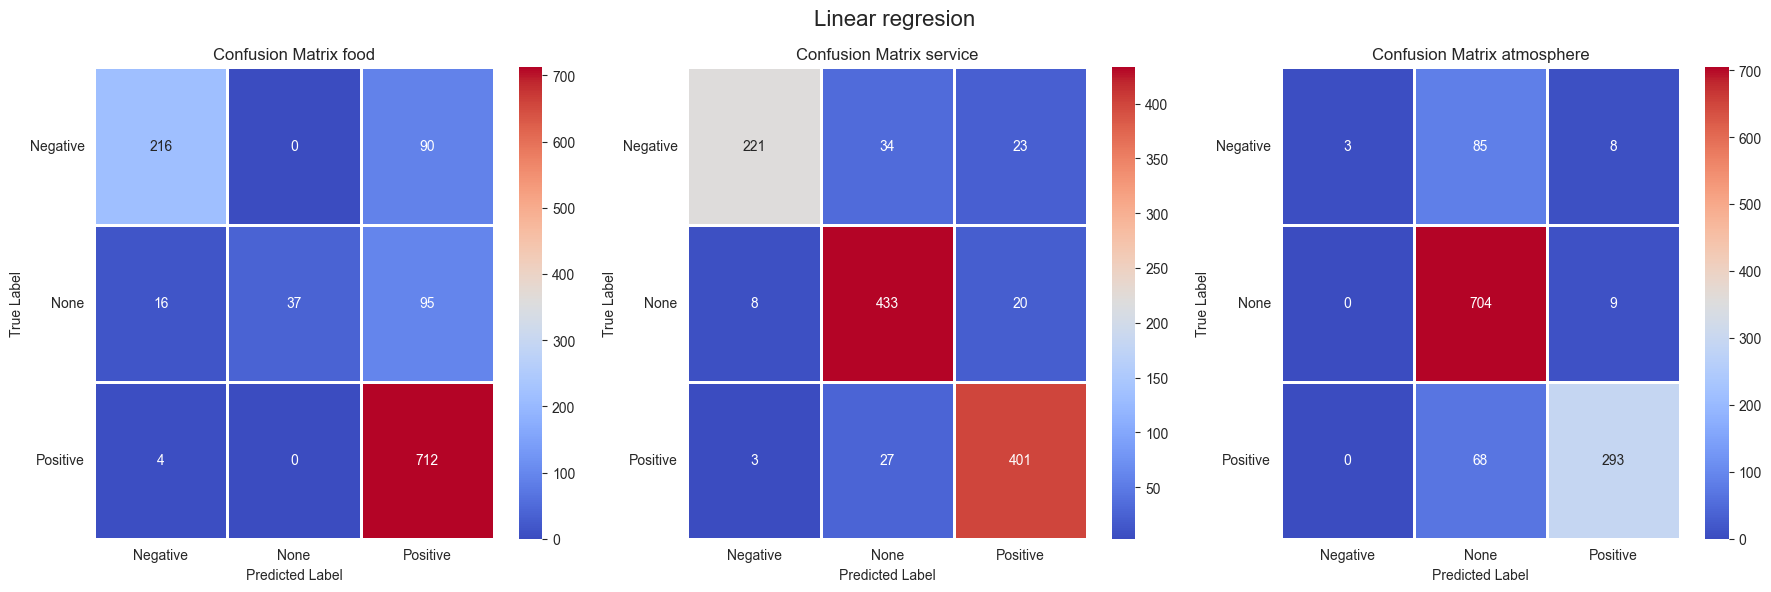

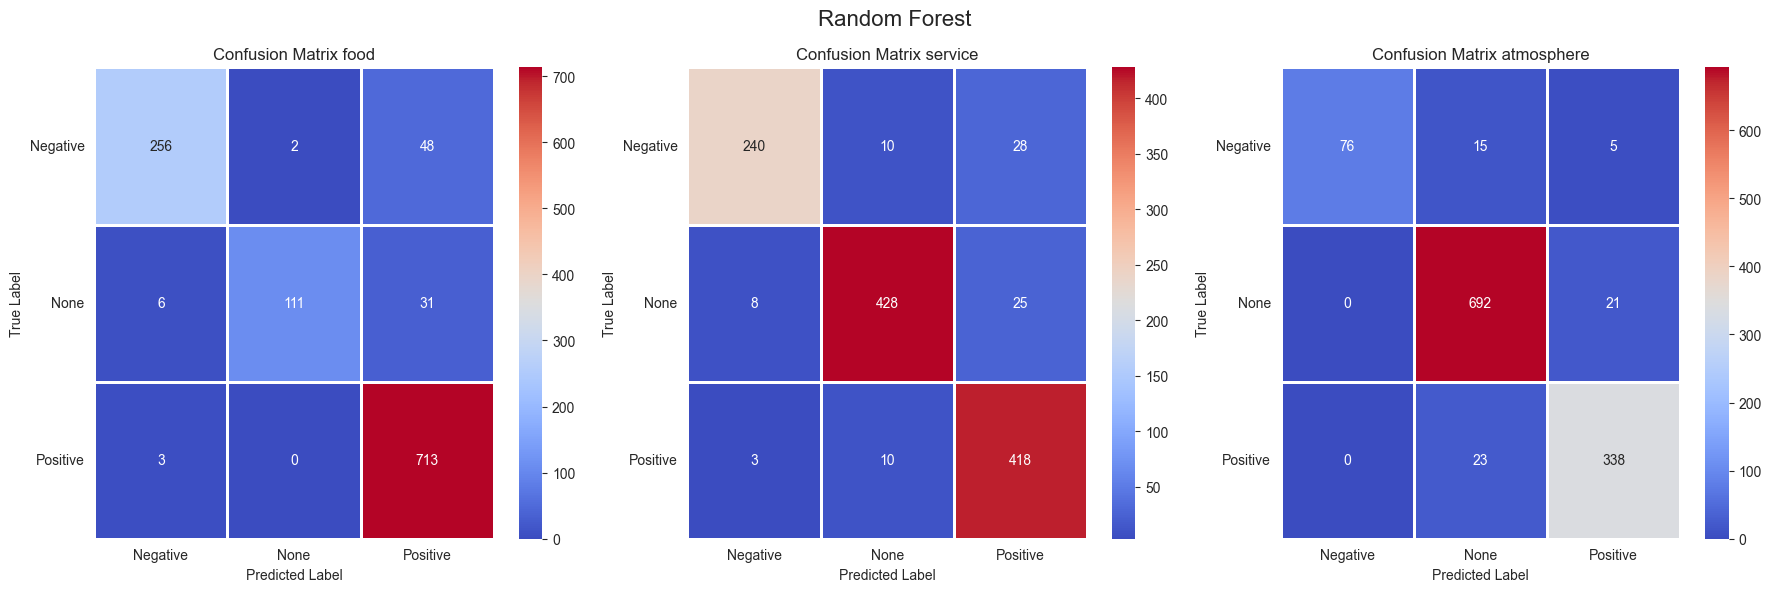

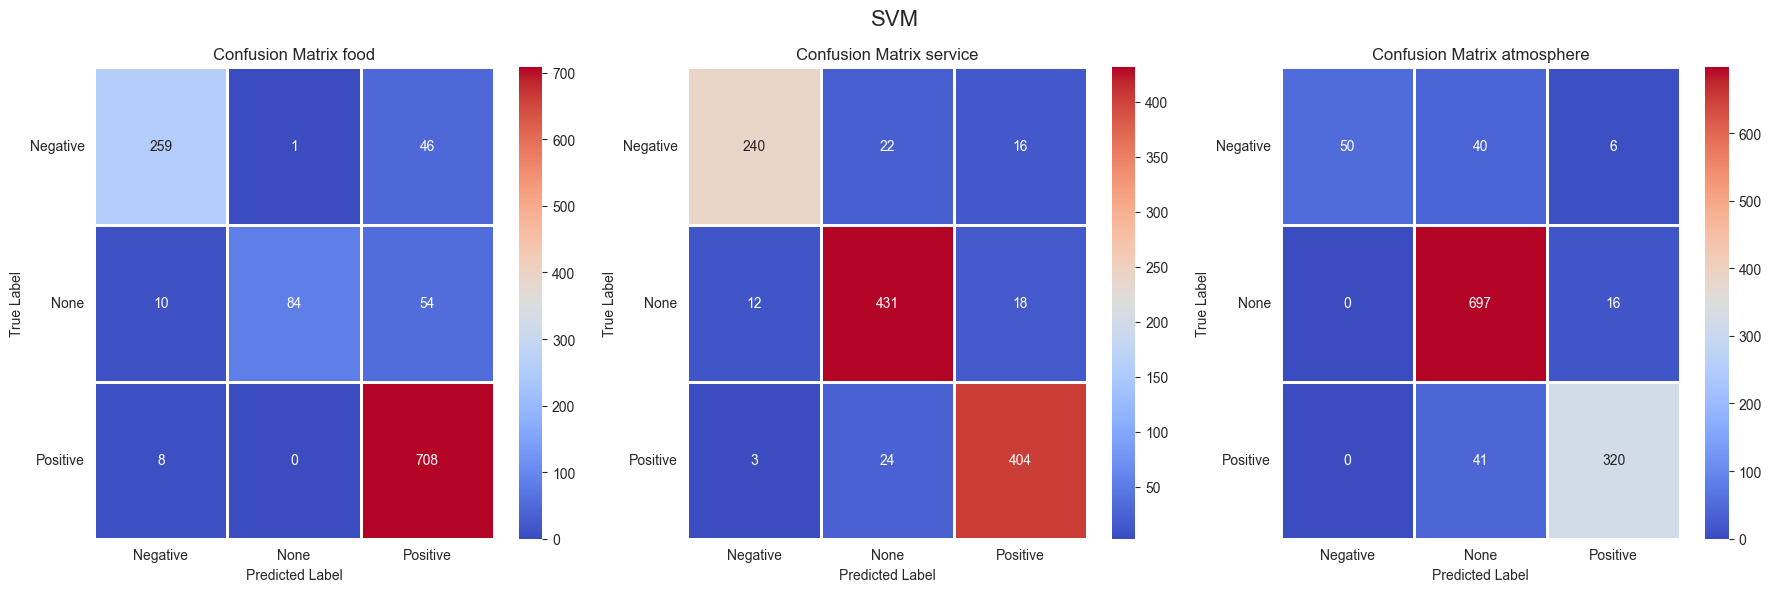

In [11]:
def create_predicions_to_list(classifier):
    predictions = classifier.predict(df['text'])
    preditions_food = [pred["food"] for pred in predictions]
    preditions_service = [pred["service"] for pred in predictions]
    preditions_atmosphere = [pred["atmosphere"] for pred in predictions]
    return preditions_food, preditions_service, preditions_atmosphere

labels_to_classificators = ["Linear regresion", "Random Forest", "SVM"]
classi_list = [classifier_lr,classifier_rf,classifier_svm]
for i in range(3):
    pred= create_predicions_to_list(classi_list[i])
    validation = [food_validation,service_validation,atmosphere_validation]
    compute_and_show_confusion_matrix(validation,pred,  labels_to_classificators[i])

In [12]:
def adjusted_weight(none, positive, negative):
    total = positive + negative
    if none > total:
        factor = (total / none) *(-2)  if none > -2 else -2
        return factor
    return 0

def Final_Rating(reviews_path,classifier):
    test_data = pd.read_csv(reviews_path)

    predictions = classifier.predict(test_data['text'])

    total_amount_of_predicions = len(predictions)
    Ratings = \
        {
            "food":{
                'None':0 ,'Positive':0,'Negative':0
            },
            "service":{
                'None':0 ,'Positive':0,'Negative':0
            },
            "atmosphere":{
                'None':0 ,'Positive':0,'Negative':0
            }
        }
    # print(Ratings)

    for i in predictions:
        for aspect in ["food","service","atmosphere"]:
            Ratings[aspect][i[aspect]] += 1

    for aspect in Ratings:
        for rate in Ratings[aspect]:
            Ratings[aspect][rate] =  round(Ratings[aspect][rate]/total_amount_of_predicions*100,2)

    food_weight = adjusted_weight(Ratings["food"]['None'], Ratings["food"]['Positive'], Ratings["food"]['Negative'])
    service_weight = adjusted_weight(Ratings["service"]['None'], Ratings["service"]['Positive'], Ratings["service"]['Negative'])
    atmosphere_weight = adjusted_weight(Ratings["atmosphere"]['None'], Ratings["atmosphere"]['Positive'], Ratings["atmosphere"]['Negative'])

    # weight_sum = food_weight + service_weight + atmosphere_weight
    # food_weight /= weight_sum
    # service_weight /= weight_sum
    # atmosphere_weight /= weight_sum

    print(food_weight,service_weight, atmosphere_weight)

    wages = {'None':0 ,'Positive':5 ,'Negative':-5}

    print(Ratings)

    a = 4 / (wages['Positive'] - wages['Negative'])

    b = 5 - a * wages['Positive']

    food_final_score = (Ratings["food"]['None'] * food_weight +
                        Ratings["food"]['Positive'] * wages['Positive'] +
                        Ratings["food"]['Negative']  * wages['Negative'])/100 *a +b
    service_final_score = (Ratings["service"]['None'] *service_weight +
                           Ratings["service"]['Positive'] * wages['Positive']
                           + Ratings["service"]['Negative'] * wages['Negative'])/100 *a +b
    atmosphere_final_score = (Ratings["atmosphere"]['None'] * atmosphere_weight +
                              Ratings["atmosphere"]['Positive'] * wages['Positive']
                              + Ratings["atmosphere"]['Negative'] * wages['Negative'])/100 *a +b




    return food_final_score,service_final_score,atmosphere_final_score,round((food_final_score+service_final_score+atmosphere_final_score)/3,1)


files = ['../test_data_reviews/2_4_review.csv',
         '../test_data_reviews/2_9_review.csv',
         '../test_data_reviews/3_4_review.csv',
         '../test_data_reviews/4_7_review.csv']

classifiers = {'Logistic Regression': classifier_lr,
               'Random Forest': classifier_rf,
               'SVM': classifier_svm}

results = []
for file in files:
    file_name = file.split('/')[-1]
    for name, clf in classifiers.items():
        rating = Final_Rating(file, clf)
        results.append({'File': file_name, 'Classifier': name, 'Food_Rating': rating[0], 'Service_Rating': rating[1],
                        'Atmosphere_Rating': rating[2], 'Average_Rating': rating[3]})

results_df = pd.DataFrame(results)

print(results_df)

0 -1.191828917969997 -0.06526228831061545
{'food': {'None': 0.0, 'Positive': 64.56, 'Negative': 35.44}, 'service': {'None': 62.66, 'Positive': 12.66, 'Negative': 24.68}, 'atmosphere': {'None': 96.84, 'Positive': 3.16, 'Negative': 0.0}}
0 -1.2245687570530388 -0.10659363808721298
{'food': {'None': 3.8, 'Positive': 75.32, 'Negative': 20.89}, 'service': {'None': 62.03, 'Positive': 18.99, 'Negative': 18.99}, 'atmosphere': {'None': 94.94, 'Positive': 5.06, 'Negative': 0.0}}
0 -1.2916392363396973 -0.0787941787941788
{'food': {'None': 1.9, 'Positive': 51.27, 'Negative': 46.84}, 'service': {'None': 60.76, 'Positive': 10.76, 'Negative': 28.48}, 'atmosphere': {'None': 96.2, 'Positive': 3.16, 'Negative': 0.63}}
0 -1.8993955936829792 -0.23838836038052605
{'food': {'None': 1.61, 'Positive': 72.26, 'Negative': 26.13}, 'service': {'None': 51.29, 'Positive': 24.52, 'Negative': 24.19}, 'atmosphere': {'None': 89.35, 'Positive': 10.65, 'Negative': 0.0}}
0 0 -0.41254523522316044
{'food': {'None': 5.48, 'Po